In [3]:
import collections
import os.path as osp
import numpy as np
import numpy.linalg as npla
import scipy.spatial.transform as sptf
np.set_printoptions(6, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 7,
})

import utils


def load_pred_poses(filename):
    data = np.loadtxt(filename)
    poses = []
    for v in data:
        T_ms = np.eye(4)
        T_ms[:3, :] = v.reshape(3, 4)
        poses.append(T_ms)

    return np.array(poses)


def load_gt_poses(filename):
    data = np.loadtxt(filename, delimiter=' ')

    poses = []
    for tq in data[:, 1:]:
        T_mr = np.eye(4)
        T_mr[:3, :3] = sptf.Rotation.from_quat(tq[3:]).as_matrix()
        T_mr[:3, 3] = tq[:3]
        poses.append(T_mr)
    return np.array(poses)


def plot_pred_poses(ax, pred_poses, gt_poses, label, color):
    T_gt_pred = gt_poses[0] @ npla.inv(pred_poses[0])
    pred_poses = T_gt_pred @ pred_poses
    ax.plot(pred_poses[:, 0, 3], pred_poses[:, 1, 3], label=label, linewidth=1.0, color=color)


gt_path = '/media/yuchen/T7/ASRL/data/dicp'
pred_path = '/ext0/ASRL/steam_icp/results/dicp/'

In [4]:
### compute kitti metric
sequences = [
    'brisbane-lagoon-freeway',
    'bunker-road',
    'bunker-road-vehicles',
    'robin-williams-tunnel',
]

local_kitti_errs = collections.defaultdict(list)
local_rpe_errs = collections.defaultdict(list)

print(f"                    KITTI metric:     t(2d)  r(2d)    t      r          RPE:     t(2d)    r(2d)      t      r")
for sequence in sequences:
  print(f"{sequence}:")
  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))[60:]

  for pred_file in ["doppler_icp", "elastic_icp", "steam_icp", "steam_dicp"]:
    ##
    pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
    # kitti metric
    t_err_2d, r_err_2d, t_err, r_err, err_3d = utils.evaluate_odometry_kitti(gt_poses, pred_poses)
    print(f"  {pred_file:<35} & {t_err_2d:.2f} & {r_err_2d:.4f} & {t_err:.2f} & {r_err:.4f}", end = '')
    local_kitti_errs[pred_file].append(err_3d)
    # rpe metric
    t_err_2d, r_err_2d, t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses)
    print(f"            & {t_err_2d:.4f} & {r_err_2d:.4f} & {t_err:.4f} & {r_err:.4f} \\\\")
    local_rpe_errs[pred_file].extend(pose_errors)

print("average: ")
for pred_file in local_kitti_errs.keys():
  errs = local_kitti_errs[pred_file]
  t_err, r_err = utils.get_avg_stats(errs)
  print(f"{pred_file:<35} & {0.0:.2f} & {0.0:.4f} & {t_err:.2f} & {r_err:.4f}", end = '')

  errs = local_rpe_errs[pred_file]
  t_err, r_err = utils.get_avg_rpe(errs)
  print(f"            & {0.0:.4f} & {0.0:.4f} & {t_err:.4f} & {r_err:.4f} \\\\")


                    KITTI metric:     t(2d)  r(2d)    t      r          RPE:     t(2d)    r(2d)      t      r
brisbane-lagoon-freeway:
  doppler_icp                         & 1.15 & 0.0015 & 1.72 & 0.0064            & 0.0226 & 0.0194 & 0.0494 & 0.0827 \\
  elastic_icp                         & 1.10 & 0.0014 & 1.54 & 0.0038            & 0.0783 & 0.0269 & 0.0801 & 0.1163 \\
  steam_icp                           & 1.69 & 0.0016 & 2.10 & 0.0040            & 0.2887 & 0.0399 & 0.2892 & 0.1195 \\
  steam_dicp                          & 1.26 & 0.0014 & 1.67 & 0.0039            & 0.0345 & 0.0297 & 0.0373 & 0.1121 \\
bunker-road:
  doppler_icp                         & 1.10 & 0.0007 & 1.66 & 0.0330            & 0.0150 & 0.0187 & 0.0246 & 0.1357 \\
  elastic_icp                         & 1.99 & 0.0014 & 2.83 & 0.0085            & 0.0389 & 0.0264 & 0.0401 & 0.1907 \\
  steam_icp                           & 1.36 & 0.0011 & 2.28 & 0.0078            & 0.0536 & 0.0209 & 0.0541 & 0.1322 \\
  steam_dicp

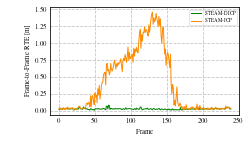

In [6]:
sequences = [
    'bunker-road',
    'bunker-road-vehicles',
    'robin-williams-tunnel',
    'brisbane-lagoon-freeway',
]
sequence = sequences[2]

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95, wspace=0.25, hspace=0.25)

gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))[60:]

##
pred_file = 'steam_dicp'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
# rpe metric
t_err_2d, r_err_2d, t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses)
rte = [utils.translation_error(e, 3) for e in pose_errors]
ax.plot(rte, label="STEAM-DICP", linewidth=1.0, color='green')

##
pred_file = 'steam_icp'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
# rpe metric
t_err_2d, r_err_2d, t_err, r_err, pose_errors = utils.evaluate_odometry_rpe(gt_poses, pred_poses)
rte = [utils.translation_error(e, 3) for e in pose_errors]
ax.plot(rte, label="STEAM-ICP", linewidth=1.0, color='darkorange')

ax.set_ylabel('Frame-to-Frame RTE [m]')
ax.set_xlabel('Frame')
ax.grid(which='both', linestyle='--', alpha=0.75)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(framealpha=0.5, fontsize=5)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/seq02_local_rte.pdf', format="pdf", bbox_inches="tight")
plt.show()

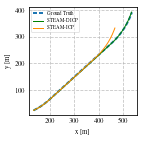

In [7]:
sequences = [
    'bunker-road',
    'bunker-road-vehicles',
    'robin-williams-tunnel',
    'brisbane-lagoon-freeway',
]
sequence = sequences[2]

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95, wspace=0.25, hspace=0.25)

gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))[60:]
ax.plot(gt_poses[:, 0, 3], gt_poses[:, 1, 3], "--", label='Ground Truth', linewidth=2.0, dashes=(2, 1))

pred_file = 'steam_dicp'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-DICP', 'green')

pred_file = 'steam_icp'
pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence+'_poses.txt'))[60:]
plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-ICP', 'darkorange')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.grid(which='both', linestyle='--', alpha=0.75)
ax.legend(framealpha=0.5, fontsize=5)
ax.tick_params(axis=u'both', which=u'both',length=0)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/seq02_path.pdf', format="pdf", bbox_inches="tight")
plt.show()